In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#ucimlrepo is for the data
from ucimlrepo import fetch_ucirepo 

In [63]:
 # Fetch the Breast Cancer Wisconsin dataset from UCI repository
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Get the features (X) and targets (y) as pandas DataFrames
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Print columns to verify the structure
#print("Feature columns:\n", X.columns)
#print("Target columns:\n", y.columns)

y = y.iloc[:, 0]  # extract the Series

# Map the diagnosis labels: 1 for malignant ('M'), 0 for benign ('B')
y = y.map({'M': 1, 'B': 0})  # Adjust this mapping as per the dataset's structure

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the input dimension
input_dim = X_train.shape[1]

In [80]:
# Define common hyperparemters 
n_epochs = 10
n_batch_size = 32
custom_exponent = -0.1
attenuation = 0

Epoch 1/10
15/15 [==============================] - 0s 6ms/step - loss: 1.6107 - accuracy: 0.6286 - val_loss: 1.0070 - val_accuracy: 0.6228
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 0.8092 - accuracy: 0.6286 - val_loss: 0.5715 - val_accuracy: 0.6228
Epoch 3/10
15/15 [==============================] - 0s 2ms/step - loss: 0.4831 - accuracy: 0.6286 - val_loss: 0.4080 - val_accuracy: 0.6228
Epoch 4/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3400 - accuracy: 0.6527 - val_loss: 0.3318 - val_accuracy: 0.6404
Epoch 5/10
15/15 [==============================] - 0s 2ms/step - loss: 0.2613 - accuracy: 0.6879 - val_loss: 0.2642 - val_accuracy: 0.7193
Epoch 6/10
15/15 [==============================] - 0s 2ms/step - loss: 0.1982 - accuracy: 0.7604 - val_loss: 0.2044 - val_accuracy: 0.7632
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 0.1575 - accuracy: 0.8022 - val_loss: 0.1713 - val_accuracy: 0.8158
Epoch 8/10
15/15 [==

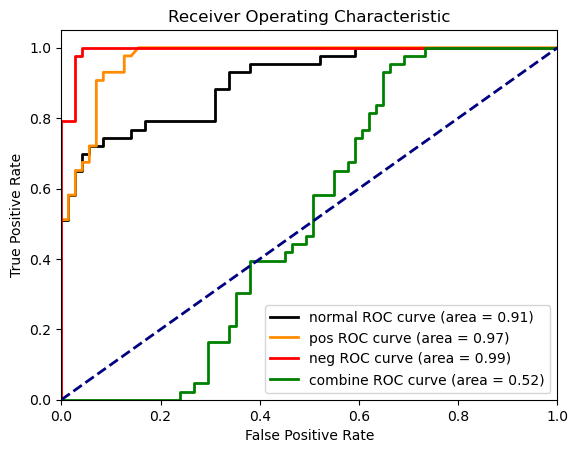

In [83]:
# function to define the shared model arhitecture 
def create_autoencoder(input_dim):
    model = Sequential([
        Dense(14, activation='relu', input_shape=(input_dim,)),
        Dense(7, activation='relu'),
        Dense(14, activation='relu'),
        Dense(1)
    ])
    return model

# Create the autoencoder models
autoencoder_normal = create_autoencoder(input_dim)
autoencoder_pos = create_autoencoder(input_dim)
autoencoder_neg = create_autoencoder(input_dim)


# Define a custom loss function for semi supervision for the positive model
def custom_loss_pos(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    modified_loss = tf.where(tf.equal(y_true, 0), mse, attenuation*(mse**custom_exponent))
    return modified_loss


def custom_loss_neg(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    modified_loss = tf.where(tf.equal(y_true, 1), mse, attenuation*(mse**custom_exponent))
    return modified_loss



# Compile the models with the Adam optimizer and MSE loss function
autoencoder_normal.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder_pos.compile(optimizer='adam', loss=custom_loss_pos, metrics=['accuracy'])
autoencoder_neg.compile(optimizer='adam', loss=custom_loss_neg, metrics=['accuracy'])


# Train the models
autoencoder_normal.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch_size, validation_data=(X_test, y_test))
autoencoder_pos.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch_size, validation_data=(X_test, y_test))
autoencoder_neg.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch_size, validation_data=(X_test, y_test))


# Generate predictions
y_pred_prob_normal = autoencoder_normal.predict(X_test).ravel()
y_pred_prob_pos = autoencoder_pos.predict(X_test).ravel()
y_pred_prob_neg = autoencoder_neg.predict(X_test).ravel()
y_pred_prob_combined = (y_pred_prob_pos - y_pred_prob_neg)/(y_pred_prob_pos + y_pred_prob_neg + 1e-10)

# Calculate ROC curves
fpr_normal, tpr_normal, thresholds_normal = roc_curve(y_test, y_pred_prob_normal)
fpr_pos, tpr_pos, thresholds_pos = roc_curve(y_test, y_pred_prob_pos)
fpr_neg, tpr_neg, thresholds_neg = roc_curve(y_test, y_pred_prob_neg)
fpr_combine, tpr_combine, thresholds_combine = roc_curve(y_test, y_pred_prob_combined)


# Get AUCs
roc_auc_normal = auc(fpr_normal, tpr_normal)
roc_auc_pos = auc(fpr_pos, tpr_pos)
roc_auc_neg = auc(fpr_neg, tpr_neg)
roc_auc_combine = auc(fpr_combine, tpr_combine)

# Plot ROC curves
plt.figure()
plt.plot(fpr_normal, tpr_normal, color='black', lw=2, label=f'normal ROC curve (area = {roc_auc_normal:.2f})')
plt.plot(fpr_pos, tpr_pos, color='darkorange', lw=2, label=f'pos ROC curve (area = {roc_auc_pos:.2f})')
plt.plot(fpr_neg, tpr_neg, color='red', lw=2, label=f'neg ROC curve (area = {roc_auc_neg:.2f})')
plt.plot(fpr_combine, tpr_combine, color='green', lw=2, label=f'combine ROC curve (area = {roc_auc_combine:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
